In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[]

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [ ]:
train_path = './dataset/train'
valid_path = './dataset/val'
test_path = './dataset/test'

breeds = [
    "Holstein_cow", "Jersey_cow", "Angus_cow", "Brahman_cow", "Hereford_cow",
    "Simmental_cow", "Limousin_cow", "Guernsey_cow", "Charolais_cow", "Ayrshire_cow"
]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=breeds, batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=breeds, batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=breeds, batch_size = 10, shuffle=False)

Found 0 images belonging to 10 classes.
Found 0 images belonging to 10 classes.
Found 0 images belonging to 10 classes.


In [ ]:
results = {}
with open('results_resnet50.pkl', 'rb') as f:
    results['ResNet50'] = pickle.load(f)
with open('results_densenet121.pkl', 'rb') as f:
    results['DenseNet121'] = pickle.load(f)
with open('mobilenetv3_results.pkl', 'rb') as f:
    results['MobileNetV3Large'] = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 730 variables whereas the saved optimizer has 734 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 346 variables whereas the saved optimizer has 350 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


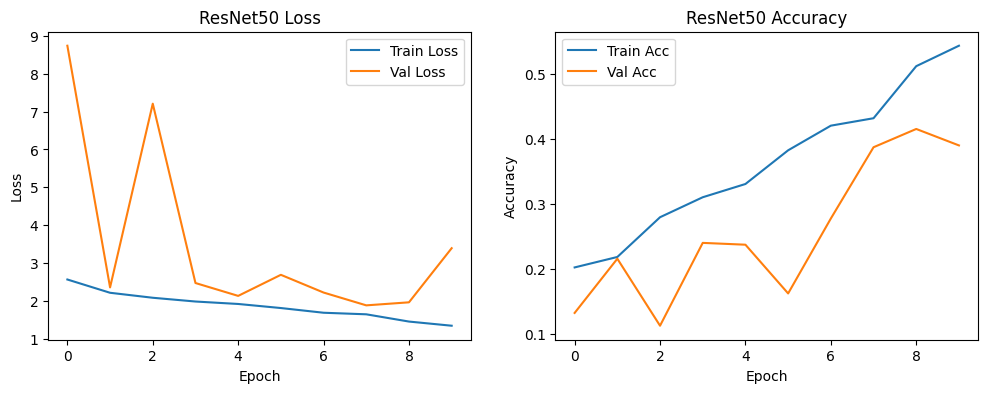

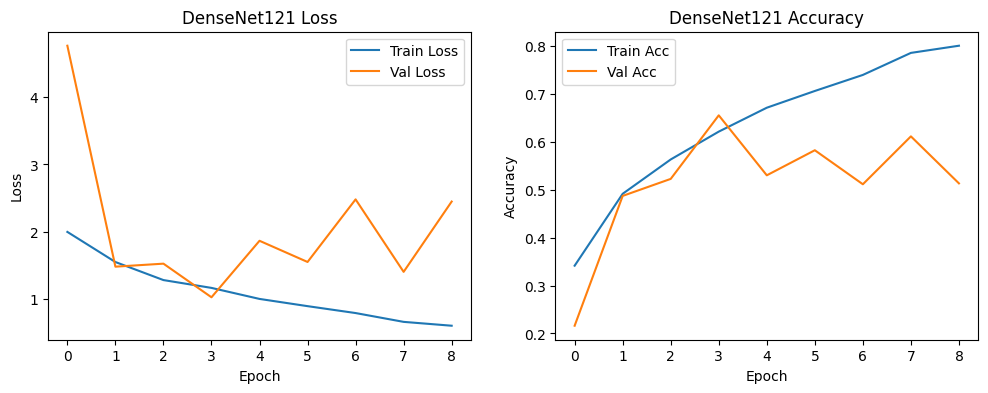

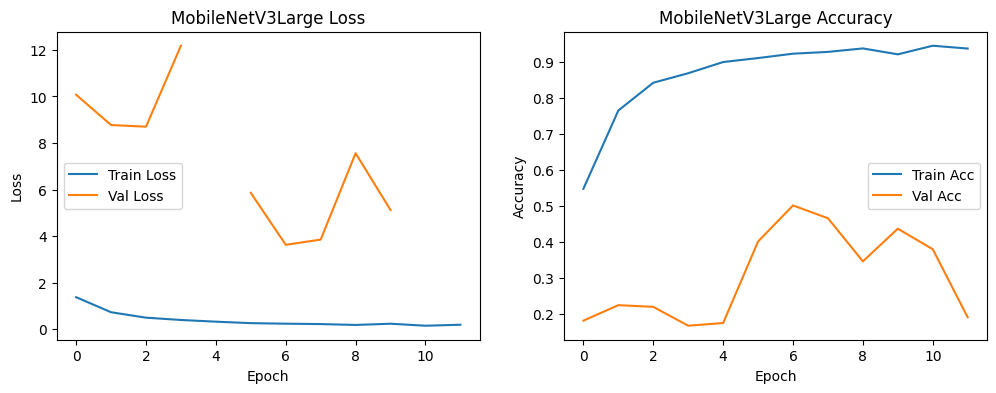

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualize training loss and accuracy for each model
for model_name, res in results.items():
    # Access the nested dictionary using the model_name as the key
    nested_res = res[model_name]
    history = nested_res['history']
    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

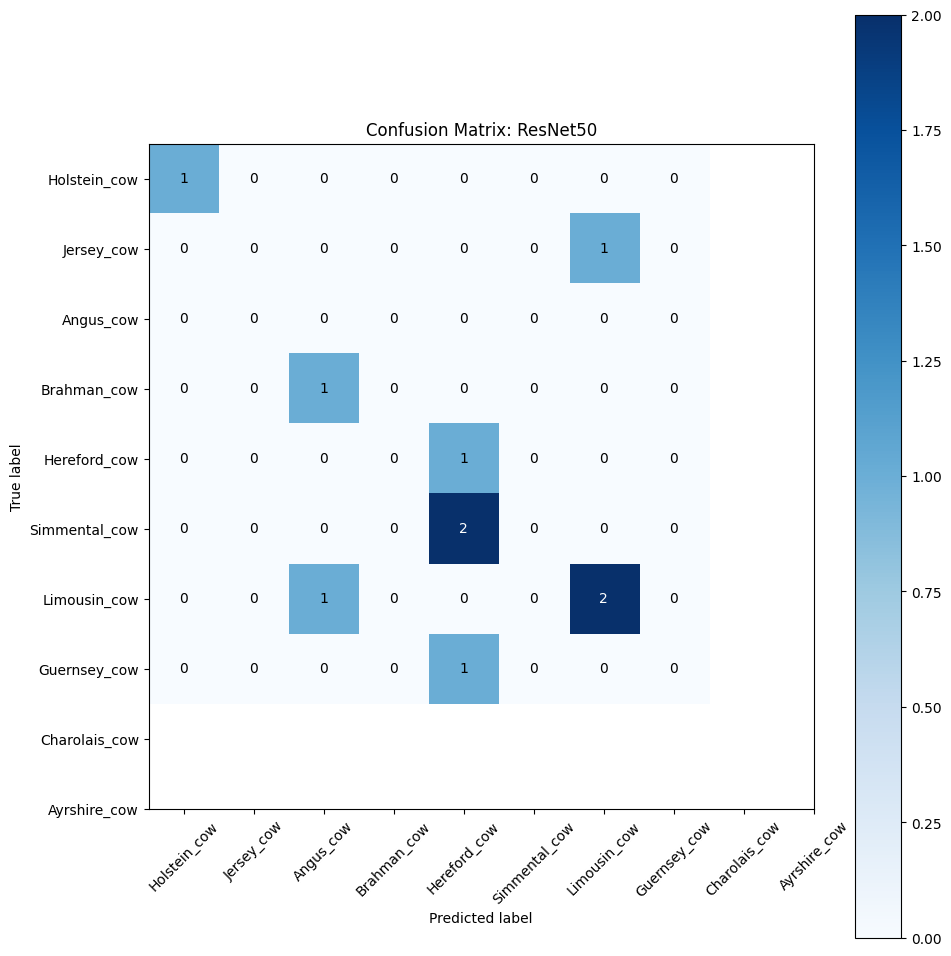

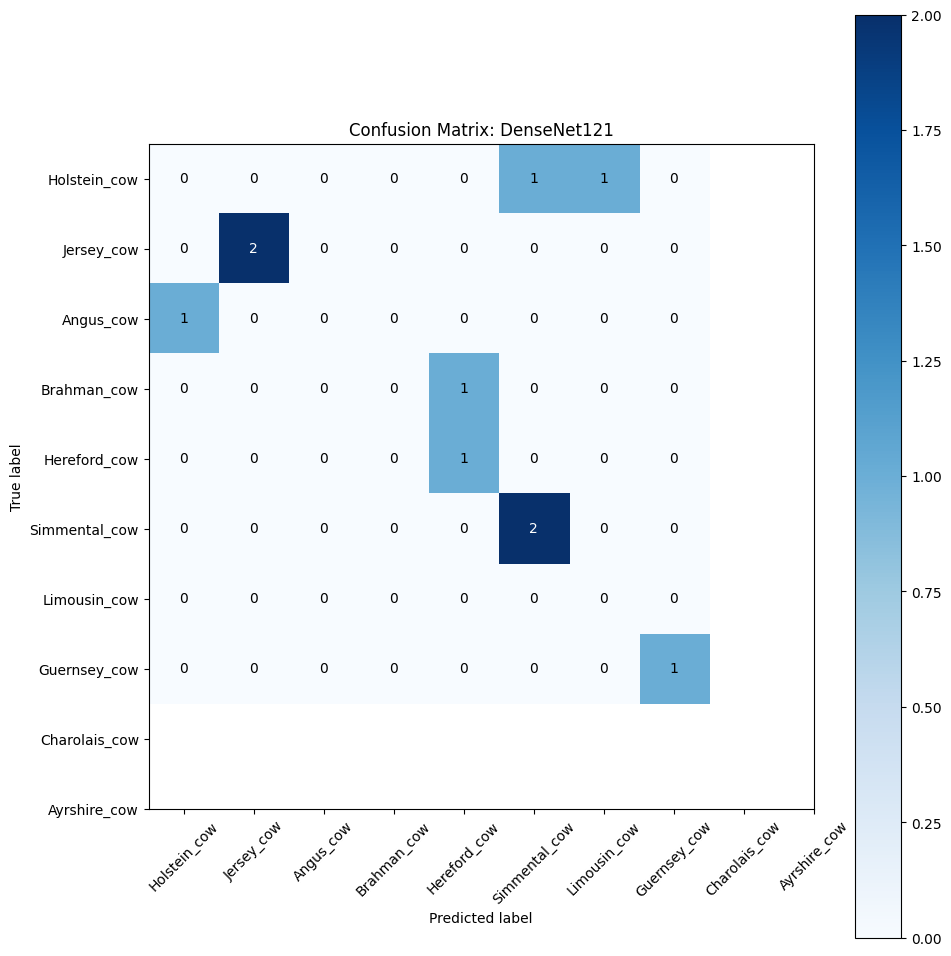

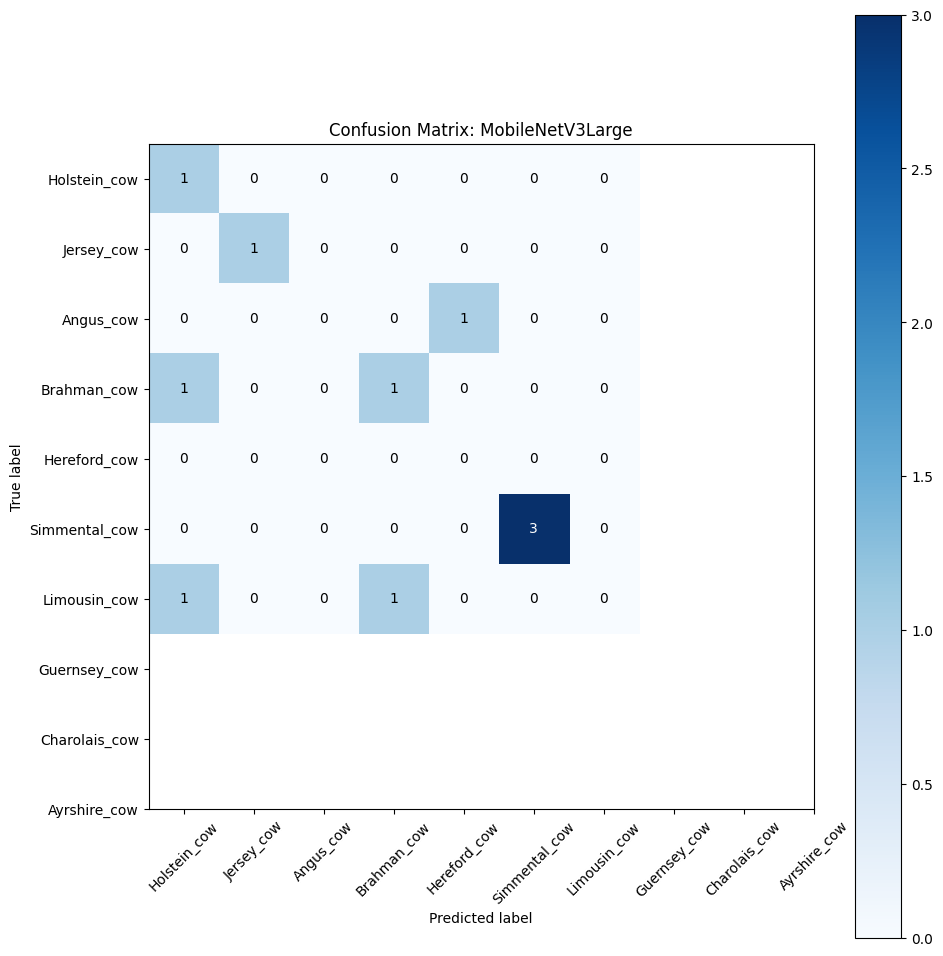

In [ ]:
for model_name, res in results.items():
    # Access the nested dictionary using the model_name as the key
    nested_res = res[model_name]
    y_true = np.argmax(nested_res['val_labels'], axis=1)
    y_pred = np.argmax(nested_res['val_preds'], axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(breeds))
    plt.xticks(tick_marks, breeds, rotation=45)
    plt.yticks(tick_marks, breeds)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
import tensorflow as tf # Import tensorflow

def mean_average_precision(y_true, y_preds):
    """
    Calculates the mean Average Precision (mAP) for multi-class classification.

    Args:
        y_true (numpy.ndarray): True labels (one-hot encoded).
        y_preds (numpy.ndarray): Predicted probabilities.

    Returns:
        float: The mean Average Precision (mAP).
    """
    num_classes = y_true.shape[1]
    average_precisions = []
    for i in range(num_classes):
        average_precisions.append(average_precision_score(y_true[:, i], y_preds[:, i]))
    return np.mean(average_precisions)

# Define the paths to the saved models
model_paths = {
    'ResNet50': 'resnet50_model.h5', # Assuming models are saved in HDF5 format
    'DenseNet121': 'densenet121_model.h5',
    'MobileNetV3Large': 'mobilenetv3_model.h5'
}

for model_name, model_path in model_paths.items():
    try:
        # Load the model
        model = tf.keras.models.load_model(model_path)

        if model is not None:
            # Ensure test_batches is re-initialized or reset if needed for consistent evaluation
            test_batches.reset()
            # Get all test images and labels from the generator
            all_test_imgs = []
            all_test_labels = []
            for i in range(len(test_batches)):
                imgs, labels = next(test_batches)
                all_test_imgs.append(imgs)
                all_test_labels.append(labels)

            test_imgs = np.concatenate(all_test_imgs)
            test_labels = np.concatenate(all_test_labels)

            test_preds = model.predict(test_imgs)
            test_acc = np.mean(np.argmax(test_preds, axis=1) == np.argmax(test_labels, axis=1))
            test_mAP = mean_average_precision(test_labels, test_preds)
            print(f"{model_name} Test Accuracy: {test_acc:.4f}, Test mAP: {test_mAP:.4f}")
        else:
            print(f"Model {model_name} could not be loaded.")
    except Exception as e:
        print(f"Error loading or evaluating model {model_name}: {e}")

Error loading or evaluating model ResNet50: [Errno 2] Unable to synchronously open file (unable to open file: name = 'resnet50_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error loading or evaluating model DenseNet121: [Errno 2] Unable to synchronously open file (unable to open file: name = 'densenet121_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Error loading or evaluating model MobileNetV3Large: [Errno 2] Unable to synchronously open file (unable to open file: name = 'mobilenetv3_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [ ]:
import pandas as pd # Import pandas

# Final conclusion
print("\nFinal Conclusion:")
summary = []
for model_name, res in results.items():
    # Access the nested dictionary using the model_name as the key
    nested_res = res[model_name]
    summary.append({
        'Model': model_name,
        'Training Time (s)': nested_res['training_time_sec'],
        'Validation Accuracy': nested_res['val_accuracy'],
        'Validation mAP': nested_res['val_mAP']
    })
df_summary = pd.DataFrame(summary)
display(df_summary.sort_values(by=['Validation Accuracy', 'Validation mAP'], ascending=False))
print("Based on the above metrics (accuracy, mAP, training time), select the model with the best trade-off for your application. Typically, the model with the highest accuracy and mAP, and reasonable training time, is preferred.")


Final Conclusion:


,Model,Training Time (s),Validation Accuracy,Validation mAP
1,DenseNet121,785.392714,0.6,0.591667
2,MobileNetV3Large,348.279154,0.6,0.450000
0,ResNet50,3417.053451,0.4,0.326389


Based on the above metrics (accuracy, mAP, training time), select the model with the best trade-off for your application. Typically, the model with the highest accuracy and mAP, and reasonable training time, is preferred.
